<h1>What's for dinenr?</h1>
<h4><i> An simple LSTM model generates dinner suggestions from partial ingredient list </i><h4>
<h4><br></h4>
<h2>Introduction</h2>


<h2>Data Cleaning</h2>

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pickle

import tensorflow as tf
import gensim.downloader as api
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer

import seaborn as sns
#from wordcloud import WordCloud

2023-08-20 18:17:46.633068: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-20 18:17:46.652190: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-20 18:17:46.797604: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-20 18:17:46.798388: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-20 18:17:47.286277: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
'''
def string_to_list(s):
    Converts a string that is formatted like a list to a list
    l = re.findall(r'\w[\w\s]+',s)
    #l = ' '.join(l)
    return l
'''

"\ndef string_to_list(s):\n    Converts a string that is formatted like a list to a list\n    l = re.findall(r'\\w[\\w\\s]+',s)\n    #l = ' '.join(l)\n    return l\n"

In [3]:
'''
#cleaning token lists
input_sequences = raw_recipes['ingredients'].apply(string_to_list).to_list()
input_sequences[:1]
'''

"\n#cleaning token lists\ninput_sequences = raw_recipes['ingredients'].apply(string_to_list).to_list()\ninput_sequences[:1]\n"

In [4]:
#precleaned dataframe will be used to clena data
precleaned_key = pd.read_pickle('ingr_map.pkl')
precleaned_key[['raw_ingr','replaced']]

,raw_ingr,replaced
0,"medium heads bibb or red leaf lettuce, washed,...",lettuce
1,mixed baby lettuces and spring greens,lettuce
2,romaine lettuce leaf,lettuce
3,iceberg lettuce leaf,lettuce
4,red romaine lettuce,lettuce
...,...,...
11654,soybeans,soybean
11655,goose,goose
11656,ajwain,ajwain
11657,brinjals,brinjal


In [5]:
cleaning_key = dict(zip(precleaned_key['raw_ingr'],precleaned_key['replaced']))

In [6]:
class CleanRecipes():
    def __init__(self,cleaning_key=cleaning_key): 
        self.raw_recipes = self.import_data()
        self.input_sequences = self.raw_recipes['ingredients'].apply(self.string_to_list).to_list()
        print(self.input_sequences)
        self.cleaned_ingredients = []
        self.cleaning_key = cleaning_key

    def __call__(self):
        self.cleaned_ingredients = self.clean_text()
        return self.raw_recipes, self.input_sequences, self.cleaned_ingredients

    def import_data(self):
        #'''Imporrhow to run a jupyter notebook in a gpu docker contqainert cleaned recipe, raw recipe and ratings data'''
        raw_recipes = pd.read_csv('RAW_recipes.csv')
        del raw_recipes['contributor_id']
        del raw_recipes['submitted']
        del raw_recipes['tags']
        del raw_recipes['steps']
        del raw_recipes['description']
        raw_recipes = raw_recipes.set_index('id')
        return raw_recipes

    def string_to_list(self,s):
        '''Converts a string that is formatted like a list to a list'''
        l = re.findall(r'\w[\w\s]+',s)
        return l

    def clean_text(self):
        #all_ingredients = [x for sublist in self.input_sequences for x in sublist]
        for recipe in self.input_sequences:
            ingredient_bundle = []
            for ingredient in recipe:
                try:
                    ingredient_bundle.append(self.cleaning_key[ingredient])
                except:
                    ingredient_bundle.append(ingredient)
            self.cleaned_ingredients.append(ingredient_bundle)
        return self.cleaned_ingredients

In [7]:
cleaner = CleanRecipes()
raw_recipes, input_sequences, cleaned_sequences = cleaner()

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [8]:
print('Cleaning example:')
print(f'Before: {input_sequences[3]}')
print(f'After:  {cleaned_sequences[3]}')

Cleaning example:
Before: ['spreadable cheese with garlic and herbs', 'new potatoes', 'shallots', 'parsley', 'tarragon', 'olive oil', 'red wine vinegar', 'salt', 'pepper', 'red bell pepper', 'yellow bell pepper']
After:  ['cheese', 'new potato', 'shallot', 'parsley', 'tarragon', 'olive oil', 'red wine vinegar', 'salt', 'pepper', 'red bell pepper', 'yellow bell pepper']


<h2><br></h2>
<h2>EDA</h2>

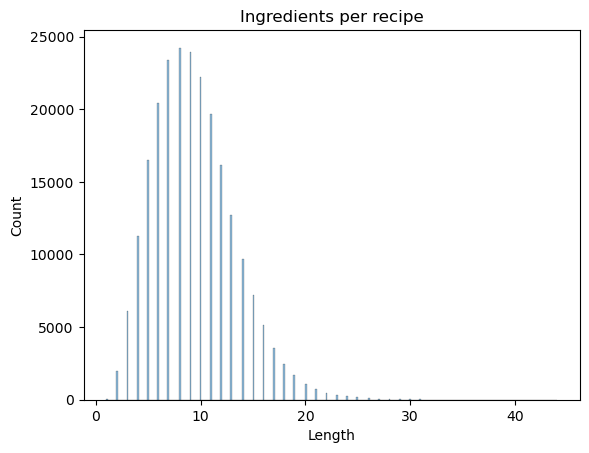

In [9]:
#ingredient list length distribution
lengths = [len(x) for x in cleaned_sequences]
sns.histplot(pd.DataFrame(lengths),legend=False)
plt.title('Ingredients per recipe')
plt.xlabel('Length')
plt.show()

In [10]:
#overview of frequencies
'''
all_words = ' '.join([x for sublist in cleaned_sequences for x in sublist])
wordcloud = WordCloud().generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word frequencies');
'''

"\nall_words = ' '.join([x for sublist in cleaned_sequences for x in sublist])\nwordcloud = WordCloud().generate(all_words)\nplt.imshow(wordcloud, interpolation='bilinear')\nplt.axis('off')\nplt.title('Word frequencies');\n"

In [11]:
#top words
def get_top(cleaned_sequences):
    ingred = [x for sublist in cleaned_sequences for x in sublist]
    ingred_counts = Counter(ingred).most_common()
    #top_ingredients = [ingred_counts[n][0] for n in range(len(ingred_counts))]
    return ingred_counts

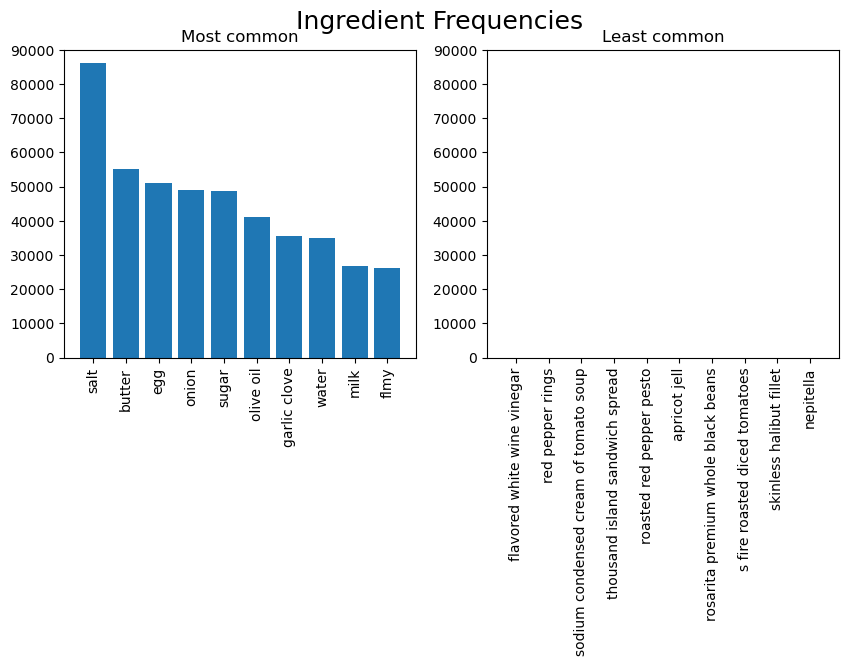

In [12]:
tops = get_top(cleaned_sequences)
sorted_ingredients = [x[0] for x in tops]
sorted_counts = [x[1] for x in tops]

count_range = 10 
plt.figure(figsize=(10,4))
plt.suptitle('Ingredient Frequencies',fontsize=18)
plt.subplot(1,2,1)
plt.bar(sorted_ingredients[:count_range], sorted_counts[:count_range])
plt.xticks(rotation=90)
plt.ylim((0,90_000))
plt.title('Most common')

plt.subplot(1,2,2)
plt.bar(sorted_ingredients[-count_range:], sorted_counts[-count_range:])
plt.xticks(rotation=90)
plt.ylim((0,90_000))
plt.title('Least common');

<h2><br></h2>
<h2>Tokenizing ingredients</h2>

In [13]:
pad_value = int(0)

In [14]:
class TokenizeRecipes():
    def __init__(self, input_sequences):
        self.tokenizer = Tokenizer()
        self.input_sequences = input_sequences
    
    def __call__(self):
        self.tokenizer, self.ngram_sequences, self.totalwords = self.get_sequence_of_tokens()
        self.max_length = self.find_max()
        self.padded_sequence = self.pad_sequences()
        self.padded_sequence = np.array(self.padded_sequence)
        self.predictors, self.label = self.padded_sequence[:,:-1],self.padded_sequence[:,-1]
        return self.tokenizer, self.max_length, self.totalwords, self.label, self.predictors

    def get_sequence_of_tokens(self):
        '''Tokenization'''    
        self.tokenizer.fit_on_texts(self.input_sequences)
        self.total_words = len(self.tokenizer.word_index) + 1

        self.ngram_sequences = []
        for line in self.input_sequences:
            token_list = self.tokenizer.texts_to_sequences([line])[0]
            for i in range(1, len(token_list)):
                n_gram_sequence = token_list[:i+1]
                self.ngram_sequences.append(n_gram_sequence)
        return self.tokenizer, self.ngram_sequences, self.total_words

    def find_max(self):
        '''find max token length'''
        self.max_length = max(len(x) for x in self.input_sequences)
        return self.max_length

    def pad_sequences(self):
        '''pad sequences (built in function returns a recursion error)'''
        self.padded_sequence = []
        for sequence_in in self.ngram_sequences:
            zeros = (self.max_length-len(sequence_in))
            padded = [pad_value for zero in range(zeros)]
            padded.extend(sequence_in)
            self.padded_sequence.append(padded)
        return self.padded_sequence

In [15]:
tokenizer,max_length,total_words,label,predictors = TokenizeRecipes(cleaned_sequences)()
total_words

12413

In [16]:
max_length

44

Embedding words using word2vec

In [17]:
api.info(name_only=True)

{'corpora': ['semeval-2016-2017-task3-subtaskBC',
  'semeval-2016-2017-task3-subtaskA-unannotated',
  'patent-2017',
  'quora-duplicate-questions',
  'wiki-english-20171001',
  'text8',
  'fake-news',
  '20-newsgroups',
  '__testing_matrix-synopsis',
  '__testing_multipart-matrix-synopsis'],
 'models': ['fasttext-wiki-news-subwords-300',
  'conceptnet-numberbatch-17-06-300',
  'word2vec-ruscorpora-300',
  'word2vec-google-news-300',
  'glove-wiki-gigaword-50',
  'glove-wiki-gigaword-100',
  'glove-wiki-gigaword-200',
  'glove-wiki-gigaword-300',
  'glove-twitter-25',
  'glove-twitter-50',
  'glove-twitter-100',
  'glove-twitter-200',
  '__testing_word2vec-matrix-synopsis']}

In [18]:
all_sequences = [x for list1 in cleaned_sequences for x in list1]

In [19]:
embed_model = api.load('word2vec-google-news-300')

In [20]:
embed_size = 300

In [21]:
def embed_one_ingredient(ingredient):
    '''Encode a single recipe'''
    recipe_embedding = []
    try:
        recipe_embedding.append(embed_model[ingredient])
    except:
        recipe_embedding.append(np.zeros((embed_size)))
    #recipe_embedding = pd.DataFrame(recipe_embedding)
    return recipe_embedding

In [22]:
test_word = cleaned_sequences[:1][0][3]
test_word

'honey'

In [23]:
embed_one_ingredient(test_word)

[array([-4.54711914e-03, -1.25976562e-01, -1.68945312e-01,  6.17675781e-02,
         1.94549561e-03,  2.57568359e-02, -9.52148438e-02, -3.39843750e-01,
        -6.53076172e-03,  1.54296875e-01,  3.88183594e-02, -3.12500000e-01,
        -3.04687500e-01,  2.23632812e-01, -1.61132812e-01,  2.15820312e-01,
        -3.02734375e-01,  1.63085938e-01, -2.73437500e-01, -2.10937500e-01,
        -2.50244141e-02,  8.00781250e-02,  1.82617188e-01, -2.51464844e-02,
        -1.61132812e-01,  5.32226562e-02, -4.68750000e-02, -3.01513672e-02,
        -2.24609375e-02, -4.15039062e-02, -2.16064453e-02, -1.03027344e-01,
        -1.22680664e-02, -1.12792969e-01, -3.28125000e-01,  1.18164062e-01,
         1.76757812e-01, -1.90429688e-01,  2.51953125e-01,  2.20703125e-01,
         1.66992188e-01, -1.87500000e-01,  1.62109375e-01,  4.34570312e-02,
        -3.51562500e-01, -2.92968750e-01, -7.86132812e-02,  8.34960938e-02,
        -5.27954102e-03, -6.68945312e-02, -2.98828125e-01,  2.81250000e-01,
        -9.8

In [24]:
def find_unique_ingredients(cleaned_sequences):
    return list(set([x for sublist in cleaned_sequences for x in sublist]))

unique_ingredients = find_unique_ingredients(cleaned_sequences)

In [25]:
def encode_recipes(unique_ingredients,tokenizer=tokenizer,embed_size=embed_size):
    '''Encode all recipes'''
    word_index = tokenizer.word_index
    recipe_embeddings = np.zeros((len(unique_ingredients)+1,embed_size))
    for ingredient,i in word_index.items():
        ingredient_embedding = embed_one_ingredient(ingredient)[0]
        recipe_embeddings[i,:] = ingredient_embedding
    #recipe_embeddings = np.delete(recipe_embeddings,0,axis=0) #dict starts at 1
    return recipe_embeddings

recipe_embeddings = encode_recipes(unique_ingredients)
print(recipe_embeddings.shape)
pd.DataFrame(recipe_embeddings).head(10)

(12413, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.057373,0.222656,0.204102,0.046631,-0.027344,0.296875,-0.102539,-0.172852,0.024414,0.310547,...,-0.357422,-0.478516,-0.131836,0.162109,0.167969,0.054199,0.166016,0.197266,-0.053955,-0.161133
2,0.078125,0.203125,0.063965,0.133789,0.096191,0.004486,0.271484,-0.421875,-0.165039,0.183594,...,-0.179688,-0.320312,-0.150391,-0.000462,0.057617,-0.186523,0.121582,-0.072266,-0.140625,-0.132812
3,-0.349609,0.076172,0.095215,0.068359,-0.054199,0.023682,0.211914,-0.104492,-0.068359,0.234375,...,-0.150391,0.059814,-0.316406,0.023926,0.125977,-0.023438,0.046143,0.089355,-0.212891,0.118164
4,-0.255859,0.170898,-0.065918,0.213867,-0.040283,0.001259,0.304688,-0.202148,-0.190430,0.171875,...,-0.194336,-0.255859,0.318359,0.044678,0.333984,0.048584,-0.061523,0.125977,0.204102,0.382812
5,-0.187500,-0.199219,-0.038574,0.206055,-0.040527,-0.094238,0.166016,-0.250000,-0.164062,-0.009827,...,-0.425781,-0.416016,0.118164,-0.109863,-0.068848,0.070312,-0.093750,0.193359,0.213867,-0.049316
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,-0.151367,0.136719,0.116699,-0.178711,-0.111816,0.007446,-0.002625,-0.206055,0.009277,0.099609,...,-0.071289,-0.231445,-0.163086,0.049561,-0.102051,0.063477,-0.218750,0.008484,0.153320,-0.067383
9,-0.073242,0.132812,-0.006989,0.156250,0.070312,0.105957,0.312500,-0.437500,-0.049316,0.211914,...,-0.134766,-0.216797,0.044922,0.048828,-0.046143,0.102051,-0.065918,0.238281,0.094727,-0.253906


In [26]:
#preparing test and train sets

In [27]:
#shuffeling labels and predictors 
shuffled_index = np.random.permutation(len(predictors))
predictors = predictors[shuffled_index]
label = label[shuffled_index]

In [28]:
#shifting data to match encoding matrix
'''
label=label.reshape(-1,1)
label = label-1

predictors = predictors-1
'''

'\nlabel=label.reshape(-1,1)\nlabel = label-1\n\npredictors = predictors-1\n'

In [29]:
label.min(), label.max()

(1, 12412)

In [30]:
predictors.max(), predictors.min()

(12412, 0)

In [31]:
predictors

array([[  0,   0,   0, ...,   1, 448, 104],
       [  0,   0,   0, ..., 526,  28, 221],
       [  0,   0,   0, ...,   0,   0,  59],
       ...,
       [  0,   0,   0, ...,   0,   0, 137],
       [  0,   0,   0, ..., 958,  12,   2],
       [  0,   0,   0, ...,   7,   4, 156]])

In [32]:
label

array([  7, 806, 370, ...,  28,  27, 149])

<h2><br></h2>
<h2>Building model</h2>

In [33]:
predictors.shape, label.shape, recipe_embeddings.shape,len(unique_ingredients)

((1948345, 43), (1948345,), (12413, 300), 12412)

In [34]:
predictors = tf.cast(predictors,tf.float64)
label = tf.cast(label,tf.float64)

2023-08-20 18:18:19.597671: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-20 18:18:19.687757: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [35]:
def create_model(embed_size=embed_size, unique_ingredients=len(unique_ingredients), recipe_embeddings=recipe_embeddings):
    '''Build LSTM model'''
    input_len = max_length-1
    model = Sequential()
    model.add(Embedding(unique_ingredients+1, embed_size, weights=[recipe_embeddings], trainable=False, mask_zero=True, input_length=input_len)) 
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    model.add(Dense(unique_ingredients, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam')
    return model

In [36]:
print(tf.config.list_physical_devices('GPU'))

[]


In [ ]:
#run on cpu because gpu has glitch with mask_zero=True
with tf.device('/cpu:0'):
    model = create_model()
    history = model.fit(predictors, label, epochs=5)

Epoch 1/5
23568/60886 [==========>...................] - ETA: 9:00 - loss: 5.7401

<h2><br></h2>
<h2>Predicting what's for dinner</h2>

In [43]:
def pad_sequences(token_list, max_length=max_length):
    '''pad sequences (built in function returns a recursion error)'''
    padded_sequence = []
    zeros = (max_length-len(token_list))-1
    padded = [int(0) for zero in range(zeros)]
    padded.extend(token_list)
    return padded

In [90]:
def cook_for_me(seed_text, model):
    next_words = 5
    words_out = []
    token_list = []

    seed_text = seed_text.split(' ')
    for word in seed_text:
        token_ = tokenizer.texts_to_sequences([word])[0]
        token_list.extend(token_)
    token_list = pad_sequences(token_list)
        
    while next_words > 0:
        proba = model.predict(np.array(token_list).reshape(-1,43), verbose=0)
        predicted = np.argmax(proba, axis=1)
        new_token = int(predicted[0])
        word = list(tokenizer.word_index.keys())[int(predicted[0]-1)]
        words_out.append(word)
        token_list.append(new_token)
        token_list.pop(0)
        next_words -= 1
    words_out = list(set(words_out))
    string_out = 'Why not try adding some '+', '.join(words_out[:-1])+' and '+words_out[-1]+'?'
    return string_out

In [45]:
def make_suggestions(ingredients_in_stock):
    for ingredient in ingredients_in_stock:
        split_ingredients = ' and '.join(ingredient.split(' '))
        greeting = 'For '+split_ingredients.upper() +' let me see... '
        print(greeting)
        print(cook_for_me(ingredient,model))
        print('')

In [96]:
ingredients_in_stock = ['chicken','chicken rice','tuna mayonnaise','pineapple']
make_suggestions(ingredients_in_stock)

For CHICKEN let me see... 
Why not try adding some  and nepitella?

For CHICKEN AND RICE let me see... 
Why not try adding some  and nepitella?

For TUNA AND MAYONNAISE let me see... 
Why not try adding some  and nepitella?

For PINEAPPLE let me see... 
Why not try adding some  and nepitella?

